In [ ]:
import sys
import json
import torch
from torch import nn
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification\
    , BertForPreTraining, AutoModel
from transformers import XLMTokenizer, XLMWithLMHeadModel


from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import random
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, mean_squared_error
import time

In [ ]:
from transformers import XLMTokenizer, XLMWithLMHeadModel
tokenizer = XLMTokenizer.from_pretrained("xlm-mlm-100-1280")
model = XLMWithLMHeadModel.from_pretrained("xlm-mlm-100-1280")

In [ ]:
torch.manual_seed(7)
random.seed(7)
np.random.seed(7)
# Setting PyTorch's required configuration variables for reproducibility.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False
torch.use_deterministic_algorithms(False)

In [ ]:
#PRE_TRAINED_MODEL = 'bert-base-multilingual-cased'
PRE_TRAINED_MODEL = 'xlm-mlm-100-1280'



In [ ]:
MAXTOKENS = 5
NUM_EPOCHS = 2000  # default maximum number of epochs
BERT_EMB = 768  # set to either 768 or 1024 for BERT-Base and BERT-Large models respectively
BS = 8  # batch size
INITIAL_LR = 1e-5  # initial learning rate
save_epochs = [1, 2, 3, 4, 5, 6, 7]  # these are the epoch numbers (starting from 1) to test the model on the test set
# and save the model checkpoint.
EARLY_STOP_PATIENCE = 30  # If model does not improve for this number of epochs, training stops.

# Setting GPU cards to use for training the model. Make sure you read our paper to figure out if you have enough GPU
# memory. If not, you can change all of them to 'cpu' to use CPU instead of GPU. By the way, two 24 GB GPU cards are
# enough for current configuration, but in case of developing based on this you may need more (that's why there are
# three cards declared here)
# CUDA_0 = 'cuda:1'
# CUDA_1 = 'cuda:1'
# CUDA_2 = 'cuda:1'
args = sys.argv
epochs = NUM_EPOCHS

In [ ]:
original_df = pd.read_csv("/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/train_final.csv")
original_df

In [ ]:
#l1 = list(original_df["loan_word"])
#l2 = list(original_df["original_word"])
#get the cosine similarities from M BERT from the train set
l1 = list(original_df["loan_word"])
l2 = list(original_df["original_word"])

In [ ]:
original_df = original_df.loc[original_df["original_word"]!='Refulgent']


In [ ]:
original_df 

In [ ]:
MAXTOKENS = 512
BERT_EMB = 768  # set to either 768 or 1024 for BERT-Base and BERT-Large models respectively
#CUDA_0 = 'cuda:1'
#CUDA_1 = 'cuda:1'
#CUDA_2 = 'cuda:1'
CUDA_0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#CUDA_1 = 'cuda:0'
#CUDA_2 = 'cuda:0'

# The function for printing in both console and a given log file.
def myprint(mystr, logfile):
    print(mystr)
    print(mystr, file=logfile)


# The function for loading datasets from parallel tsv files and returning texts in lists.
def load_data(file_name):
    try:
        # f = open(file_name)
        f = pd.read_csv(file_name, sep='\t', names=['l1_text', 'l2_text'])#, 'extra'])
    except:
        print('my log: could not read file')
        exit()
    print("This many number of rows were removed from " + file_name.split("/")[-1] + " due to having missing values: ",
          f.shape[0] - f.dropna().shape[0])
    f.dropna(inplace=True)
    l1_texts = f['l1_text'].values.tolist()
    l2_texts = f['l2_text'].values.tolist()
    print(len(l1_texts), len(l2_texts))
    print(l1_texts[500])
    print("\n")
    print(l2_texts[500])
    return l1_texts, l2_texts


# Overriding the Dataset class required for the use of PyTorch's data loader classes.
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, l1_encodings, l2_encodings):
        self.l1_encodings = l1_encodings
        self.l2_encodings = l2_encodings

    def __getitem__(self, idx):
        item = {('l1_' + key): torch.tensor(val[idx]) for key, val in self.l1_encodings.items()}
        item2 = {('l2_' + key): torch.tensor(val[idx]) for key, val in self.l2_encodings.items()}
        item.update(item2)
        # item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.l1_encodings['attention_mask'])


class MyDataset1(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.l1_encodings['attention_mask'])


class MyModel(nn.Module):
    # Each component other than the Transformer, are in a sequential layer (it is not required obviously, but it is
    # possible to stack them with other layers if desired)
    def __init__(self, base_model, n_classes, dropout=0.05):
        super().__init__()
        # self.base_model = base_model.to(CUDA_0)
        self.transformation_learner = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(BERT_EMB, BERT_EMB),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(BERT_EMB, BERT_EMB),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(BERT_EMB, BERT_EMB),
            nn.LeakyReLU()
        ).to(CUDA_0)

    def forward(self, input, **kwargs):
        l1_pooler_output = input
        # l2 = input2
        # if 'l1_attention_mask' in kwargs:
        #     l1_attention_mask = kwargs['l1_attention_mask']
            # l2_attention_mask = kwargs['l2_attention_mask']
        # else:
        #     print("my err: attention mask is not set, error maybe")
        # here we use only the CLS token
        # l1_pooler_output = self.base_model(l1.to(CUDA_0), attention_mask=l1_attention_mask.to(CUDA_0)).pooler_output
        myoutput = self.transformation_learner(l1_pooler_output)
        return myoutput


# The function to compute and print the performance measure scores using sklearn implementations.
def evaluate_model(labels, predictions, titlestr, logfile):
    myprint(titlestr, logfile)
    conf_matrix = confusion_matrix(labels, predictions)
    myprint("Confusion matrix- \n" + str(conf_matrix), logfile)
    acc_score = accuracy_score(labels, predictions)
    myprint('  Accuracy Score: {0:.2f}'.format(acc_score), logfile)
    myprint('Report', logfile)
    cls_rep = classification_report(labels, predictions)
    myprint(cls_rep, logfile)
    return f1_score(labels, predictions)  # return f-1 for positive class (sarcasm) as the early stopping measure.

In [ ]:
print("key word pair number: ",len(l1))

In [ ]:
with torch.no_grad():
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    tokenizer.model_max_length = MAXTOKENS
    l1_encodings = tokenizer(l1, truncation=False, padding=True, max_length=MAXTOKENS)
    l2_encodings = tokenizer(l2, truncation=False, padding=True, max_length=MAXTOKENS)
    dataset = MyDataset(l1_encodings, l2_encodings)
    data_loader = DataLoader(dataset, batch_size=BS, shuffle=False)  # shuffle False for reproducibility
    base_model = BertModel.from_pretrained(PRE_TRAINED_MODEL).to(CUDA_0)
    base_model.eval()
    cos_s = torch.nn.CosineSimilarity()
    print("\n\n\n\n")
    sim_lst = []
    sim_lst_test = []
    for step, batch in enumerate(data_loader):
        l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0),
                                      attention_mask=batch['l1_attention_mask'].to(CUDA_0),
                                      return_dict=True).last_hidden_state[:, 1, :]
        l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0),
                                      attention_mask=batch['l2_attention_mask'].to(CUDA_0),
                                      return_dict=True).last_hidden_state[:, 1, :]
        sims = cos_s(l1_vector, l2_vector).data.cpu().numpy()
        #sim_lst.extend(list(sims))
        sim_lst_test.extend(list(sims))
print(len(sim_lst_test))
      # print("Similarities: ")
      # for i in range(len(sims)):
      #   print(l1[i], ' and ', l2[i], ' : ', sims[i])

In [ ]:
with torch.no_grad():
    #tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    tokenizer = XLMTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    #model = XLMWithLMHeadModel.from_pretrained("xlm-mlm-100-1280")
    
    tokenizer.model_max_length = MAXTOKENS
    l1_encodings = tokenizer(l1, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    l2_encodings = tokenizer(l2, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    #l1_encodings = tokenizer(text =l5,text_pair = l6 , truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    #l2_encodings = tokenizer(text =l6,text_pair = l5, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask=True)
    
    dataset = MyDataset(l1_encodings, l2_encodings)
    data_loader = DataLoader(dataset, batch_size=BS, shuffle=False)  # shuffle False for reproducibility
    base_model = XLMWithLMHeadModel.from_pretrained(PRE_TRAINED_MODEL).to(CUDA_0)
    base_model.eval()
    cos_s = torch.nn.CosineSimilarity()
    print("\n\n\n\n")
    xlm_sim_lst_equi = []
    for step, batch in enumerate(data_loader):
#         l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0),
#                                       attention_mask=batch['l1_attention_mask'].to(CUDA_0),
#                                       return_dict=True, output_hidden_states =True) 
        l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0),output_hidden_states =True )[0] 
#         l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0),
#                                       attention_mask=batch['l2_attention_mask'].to(CUDA_0),
#                                       return_dict=True, output_hidden_states=True) 
        l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0), output_hidden_states =True) [0]
        print(l1_vector.shape)
        #print(l1_vector[0][0].shape,l2_vector[1].shape )
        sims = cos_s(l1_vector[:,0,:],l2_vector[:,0,:]).data.cpu().numpy()
        xlm_sim_lst_equi.extend(list(sims))
#print(len(sim_lst_equi))

In [ ]:
train['mbert_cos_similarity'] = sim_lst



In [ ]:
test['mbert_cos_similarity'] = sim_lst_test

In [ ]:
test['xlm_cos_similarity'] = xlm_sim_lst_equi

In [ ]:
train['xlm_cos_similarity'] =xlm_sim_lst_equi

In [ ]:
test

In [ ]:
import pandas as pd
equiv = pd.read_csv("/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/datasets/Hindi-Persian-Synonyms.csv")
rand = pd.read_csv("/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/datasets/Hindi-Persian-Randoms.csv")
train = pd.read_csv("/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/train_final.csv")
test =pd.read_csv("/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/test_final.csv")

In [ ]:
#drop the English word 'Refulgent out of train set'

train = train.loc[train['original_word'] !='Refulgent'] 

In [ ]:
#create the list of orig and loan words for getting the embeddings from mbert, and XLM for train and test sets

l1 = list(train["loan_word"])
l2 = list(train["original_word"])

#l1 = list(test["loan_word"])
#l2 = list(test["original_word"])
len(l1), len(l2)


In [ ]:
test

In [ ]:
l5 = list(train['loan_word'])
l6=list(train['original_word'])
len(l5), len(l6)

In [ ]:
l7 = l5[0:7]
l8=l6[0:7]
l7,l8

In [ ]:
base_model = XLMWithLMHeadModel.from_pretrained(PRE_TRAINED_MODEL).to(CUDA_0)
l1_encodings = tokenizer(text =l7,text_pair = l8 , truncation=False, padding=True, max_length=MAXTOKENS)
l2_encodings = tokenizer(text =l8,text_pair = l7, truncation=False, padding=True, max_length=MAXTOKENS)
l2_encodings

In [ ]:
tokens=[0, 47790, 7657, 1, 179243, 167068, 1, 2]
tokenizer.decode(tokens)


In [ ]:
l7, l8

In [ ]:
with torch.no_grad():
    #tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    tokenizer = XLMTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    #model = XLMWithLMHeadModel.from_pretrained("xlm-mlm-100-1280")
    
    tokenizer.model_max_length = MAXTOKENS
    #l1_encodings = tokenizer(l7, truncation=True, padding=True, max_length=MAXTOKENS, return_tensors="pt")
    #l2_encodings = tokenizer(l8, truncation=True, padding=True, max_length=MAXTOKENS, return_tensors="pt")
    l1_encodings = tokenizer(text =l7,text_pair = l8 , truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    l2_encodings = tokenizer(text =l8,text_pair = l7, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask=True)
    dataset = MyDataset(l1_encodings, l2_encodings)
    data_loader = DataLoader(dataset, batch_size=BS, shuffle=False)  # shuffle False for reproducibility
    base_model = XLMWithLMHeadModel.from_pretrained(PRE_TRAINED_MODEL).to(CUDA_0)
    base_model.eval()
    cos_s = torch.nn.CosineSimilarity()
    print("\n\n\n\n")
    xlm_sim_lst_equi_exp = []
    for step, batch in enumerate(data_loader):
#         l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0),
#                                       attention_mask=batch['l1_attention_mask'].to(CUDA_0),
#                                       return_dict=True, output_hidden_states =True) 
        l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0), output_hidden_states =True)[0]
        print(len(l1_vector))
#         l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0),
#                                       attention_mask=batch['l2_attention_mask'].to(CUDA_0),
#                                       return_dict=True, output_hidden_states=True) 
        l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0), output_hidden_states =True)[0] 
        #print(l1_vector.hidden_states,l2_vector.hidden_states )
        sims = cos_s(l1_vector[:,4,:],l2_vector[:,4,:]).data.cpu().numpy()
        xlm_sim_lst_equi_exp.extend(list(sims))
#print(len(sim_lst_equi))

In [ ]:
l2_vector.shape

# Cosine similarities using XLM layers, middle and last. 

In [ ]:
with torch.no_grad():
    #tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    tokenizer = XLMTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    #model = XLMWithLMHeadModel.from_pretrained("xlm-mlm-100-1280")
    
    tokenizer.model_max_length = MAXTOKENS
    l1_encodings = tokenizer(l5, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    l2_encodings = tokenizer(l6, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    #l1_encodings = tokenizer(text =l5,text_pair = l6 , truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask =True)
    #l2_encodings = tokenizer(text =l6,text_pair = l5, truncation=False, padding=True, max_length=MAXTOKENS, return_tensors="pt", return_special_tokens_mask=True)
    
    dataset = MyDataset(l1_encodings, l2_encodings)
    data_loader = DataLoader(dataset, batch_size=BS, shuffle=False)  # shuffle False for reproducibility
    base_model = XLMWithLMHeadModel.from_pretrained(PRE_TRAINED_MODEL).to(CUDA_0)
    base_model.eval()
    cos_s = torch.nn.CosineSimilarity()
    print("\n\n\n\n")
    xlm_sim_lst_equi = []
    for step, batch in enumerate(data_loader):
#         l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0),
#                                       attention_mask=batch['l1_attention_mask'].to(CUDA_0),
#                                       return_dict=True, output_hidden_states =True) 
        l1_vector = base_model(batch['l1_input_ids'].to(CUDA_0),output_hidden_states =True )[0] 
#         l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0),
#                                       attention_mask=batch['l2_attention_mask'].to(CUDA_0),
#                                       return_dict=True, output_hidden_states=True) 
        l2_vector = base_model(batch['l2_input_ids'].to(CUDA_0), output_hidden_states =True) [0]
        #print(l1_vector[0][0].shape,l2_vector[1].shape )
        sims = cos_s(l1_vector[:,0,:],l2_vector[:,0,:]).data.cpu().numpy()
        xlm_sim_lst_equi.extend(list(sims))
#print(len(sim_lst_equi))
      # print("Similarities: ")
      # for i in range(len(sims)):
      #   print(l1[i], ' and ', l2[i], ' : ', sims[i])

In [ ]:
l2_vector.shape

# Random words Cosine sim using SOS token no clear threshold/separation between equivalent words, no truncation 

In [ ]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(xlm_sim_lst_equi)

# Equivalent words Cosine sim using BOS/classification  token no clear threshold/separation between equivalent words, no truncation 

In [ ]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(xlm_sim_lst_equi)

# Equivalent words Cosine sim using middle token, some threshold emerges between cosine sims , no truncation of words

In [ ]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(xlm_sim_lst_equi)

# Equivalent words Cosine sim using EOS token, huge peak with cos sim of 1 , no truncation of words

In [ ]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(xlm_sim_lst_equi)

In [ ]:
equiv["xlm_cos_similarity"] = xlm_sim_lst_equi
equiv["mbert_cos_similarity"] =sim_lst
equiv 

# Mean and Std for XLM cos sim

In [ ]:
ordered_mean = np.mean(xlm_sim_lst_equi)
 
ordered_std = np.std(xlm_sim_lst_equi)
 
print("ordered_mean: ", ordered_mean)
 
print("ordered_std: ", ordered_std)

# Mean and Std for mbert cos sim

In [ ]:
ordered_mean = np.mean(sim_lst)
 
ordered_std = np.std(sim_lst)
 
print("ordered_mean: ", ordered_mean)
 
print("ordered_std: ", ordered_std)

# Outliers from Z score for XLM cos sim

In [ ]:
threshold = 2
xlm_ordered_outlier_idx = []
for i in range(len(xlm_sim_lst_equi)):
    z = abs(xlm_sim_lst_equi[i]-ordered_mean)/ordered_std
    if z > threshold:
        xlm_ordered_outlier_idx.append(i)
print('outlier indices are', xlm_ordered_outlier_idx, len(xlm_ordered_outlier_idx))

In [ ]:
xlm_equiv_outlier = equiv.loc[xlm_ordered_outlier_idx]


# Outliers with low cos sim from XLM and Mbert

In [ ]:
equiv_outlier_lowcos = xlm_equiv_outlier.loc[(xlm_equiv_outlier['xlm_cos_similarity'] <0.35) & (xlm_equiv_outlier['mbert_cos_similarity']<0.35)]
equiv_outlier_lowcos.to_csv('Outliers_XLM_Mbert_lowcosim.csv')

In [ ]:

f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.kdeplot(data= equiv_outlier_lowcos, x=dist_arr[i,j], shade=1, ax=axs[i][j], legend=True)

# Outliers with high cos sim from XLM and Mbert

In [ ]:
equiv_outlier_highcos = equiv.loc[(equiv['xlm_cos_similarity'] >0.68) & (equiv['mbert_cos_similarity']>0.6)]
equiv_outlier_highcos.to_csv('Outliers_XLM_Mbert_highcosim.csv')

In [ ]:
sns.distplot(equiv_outlier_highcos['xlm_cos_similarity'])

In [ ]:
f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.kdeplot(data= equiv_outlier_highcos, x=dist_arr[i,j], shade=1, ax=axs[i][j], legend=True)

In [ ]:
xlm_equiv_outlier_lowcos = equiv.loc[equiv['xlm_cos_similarity'] <0.23]
xlm_equiv_outlier_lowcos

In [ ]:
xlm_equiv_outlier_highcos = equiv.loc[equiv['xlm_cos_similarity'] ==1]
xlm_equiv_outlier_highcos 

In [ ]:
equiv["xlm_cos_similarity"] = xlm_sim_lst_equi

In [ ]:
equiv

# Cosine similarity and Outliers using M-bert cased

In [ ]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(sim_lst_equi)

In [ ]:
equiv["cos_similarity"] = sim_lst_equi

In [ ]:
ordered_mean = np.mean(sim_lst_equi)
 
ordered_std = np.std(sim_lst_equi)
 
print("ordered_mean: ", ordered_mean)
 
print("ordered_std: ", ordered_std)
 

In [ ]:
threshold = 2
ordered_outlier_idx = []
for i in range(len(sim_lst_equi)):
    z = abs(sim_lst_equi[i]-ordered_mean)/ordered_std
    if z > threshold:
        ordered_outlier_idx.append(i)
print('outlier indice are', ordered_outlier_idx)

In [ ]:
len(ordered_outlier_idx)

In [ ]:
equov_outlier = equiv.loc[ordered_outlier_idx]

In [ ]:
equov_outlier

In [ ]:
sns.distplot(equov_outlier['cos_similarity'])

In [ ]:
equiv_outlier_lowcos = equov_outlier.loc[equov_outlier['cos_similarity'] <0.23]
equiv_outlier_lowcos.columns

In [ ]:
equiv_outlier_lowcos[[c for c in equiv_outlier_lowcos.columns if c in edit_dists_names]]
equiv_outlier_lowcos = equiv_outlier_lowcos[[*edit_dists_names]]

In [ ]:
edit_dists_names = ['Fast Levenshtein', 'Dolgo Prime Distance',
       'Feature Edit Distance', 'Hamming Feature Distance',
       'Weighted Feature Distance', 'Fast Levenshtein Distance Div Maxlen',
        ]
dist_arr = np.array(edit_dists_names).reshape(-1,3)
dist_arr


In [ ]:
f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.kdeplot(data= equiv_outlier_lowcos, x=dist_arr[i,j], shade=1, ax=axs[i][j], legend=True)

In [ ]:
equiv_outlier_highcos = equov_outlier.loc[equov_outlier['cos_similarity'] >0.7]

In [ ]:
equiv_outlier_highcos = equiv_outlier_highcos[[*edit_dists_names]]

In [ ]:
f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.kdeplot(data= equiv_outlier_highcos, x=dist_arr[i,j], shade=1, ax=axs[i][j], legend=True)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

# Get the logits for the train from the cnn/dnn for training the logistic regressor after padding to max length and concatenating loan and original word


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import panphon
import panphon.distance
import editdistance # levenshtein
import epitran
import eng_to_ipa as eng
from epitran.backoff import Backoff
from googletrans import Translator
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
epitran.download.cedict()

In [4]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import os
import torch
from torch import nn
from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline

In [6]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
#get phonetic features using panPhon
ft = panphon.FeatureTable()

In [ ]:
original_df['features_loan'] = original_df.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
original_df['features_orig'] = original_df.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)

In [ ]:
#get features for test set 
test['features_loan'] = original_df.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
test['features_orig'] = original_df.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)


In [ ]:
test

In [ ]:
#make a flat list of the features for both orig and loan words
#original_df['features_loan'] = original_df['features_loan'].apply(lambda x:sum(x, []))
original_df['features_orig'] = original_df['features_orig'].apply(lambda x:sum(x, []))

In [ ]:
test['features_orig'] = test['features_orig'].apply(lambda x:sum(x, []))

In [ ]:
test['features_loan'] = test['features_loan'].apply(lambda x:sum(x, []))

In [ ]:
max_len_loan = original_df.loan_word_epitran.map(lambda x: len(ft.word_to_vector_list(x))).max()
max_len_orig = original_df.original_word_epitran.map(lambda x: len(ft.word_to_vector_list(x))).max()

In [ ]:
max_len_loan = test.loan_word_epitran.map(lambda x: len(ft.word_to_vector_list(x))).max()
max_len_orig = test.original_word_epitran.map(lambda x: len(ft.word_to_vector_list(x))).max()

In [ ]:
max_len_loan, max_len_orig

In [ ]:
def padarray(A, size):
    t = size - len(A)
    return np.pad(A, pad_width=(0, t), mode='constant')

In [ ]:
#for train set 
pad_idx_loan = original_df['features_loan'].apply(len)
pad_idx_orig = original_df['features_orig'].apply(len)
pad_idx_loan = np.array(pad_idx_loan)
pad_idx_orig = np.array(pad_idx_orig)

In [ ]:
#for test set
pad_idx_loan = test['features_loan'].apply(len)
pad_idx_orig = test['features_orig'].apply(len)
pad_idx_loan = np.array(pad_idx_loan)
pad_idx_orig = np.array(pad_idx_orig)

In [ ]:
pad_idx_loan, pad_idx_orig

In [ ]:
#for train 
# arr_loan = np.asarray(original_df['features_loan'])
# arr_orig = np.asarray(original_df['features_orig'])
#for test 
arr_loan = np.asarray(test['features_loan'])
arr_orig = np.asarray(test['features_orig'])
 

In [ ]:
l_loan = []
for i in range(len(arr_loan)):
    a = padarray(arr_loan[i], max_len_loan*24)
    l_loan.append(a)

In [ ]:
l_orig = []
for i in range(len(arr_orig)):
    a = padarray(arr_orig[i], max_len_orig*24)
    l_orig.append(a)

In [ ]:
len(l_orig)

In [ ]:
l_comb = np.concatenate((l_loan, l_orig), axis=1)

In [ ]:
l_comb.shape

In [ ]:
lables = np.array(test['label']).reshape((-1,1))
lables.shape

In [ ]:
#x = np.append(l_comb, lables, axis=1) 
#x_test = np.append(l_comb, lables, axis=1) 
x_test.shape

In [ ]:
x_test.shape
%store x_test

In [44]:
%store -r x_test

In [7]:
%store -r x

In [45]:
x_test.shape
 

(503, 889)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
device = 'cpu'

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_features):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        
        return torch.sigmoid(logits), logits
        #return logits

In [46]:
# X_train = x[:,0:1056]
# Y_train = x[:,1056] 

X_test = x_test[:,0:888]
Y_test = x_test[:,888] 

In [47]:
X_train.shape, Y_train.shape
X_test.shape, Y_test.shape
 

((503, 888), (503,))

In [ ]:
model = NeuralNetwork(X_test.shape[1]).to(device)
print(model)

In [ ]:
model

In [ ]:
criterion = nn.BCELoss().to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [48]:
#X_train = torch.tensor(X_train).to(device)
#Y_train = torch.tensor(Y_train).to(device)

X_test= torch.tensor(X_test).to(device)
Y_test = torch.tensor(Y_test).to(device)

In [ ]:
Y_test

In [ ]:
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5).view(-1)
    return ((y_true == predicted).sum().float() / len(y_true), (y_true == predicted).sum())

In [ ]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
#train for 10000 epochs and get the logits 
test_losses = []
train_losses = []
test_accur = []
train_accur = []
logits = []
for epoch in range(1000):

#     y_pred = model(X_train.float())[0]
#     logits = model(X_train.float())[1]
    #getting logits for test set 
    y_pred = model(X_test.float())[0]
    logits = model(X_test.float())[1]
    #y_pred = model(X_train) 
    #print(y_pred)

    #y_pred = torch.squeeze(y_pred)
    #train_loss = criterion(y_pred, Y_train.float())
    
    test_loss = criterion(y_pred, Y_test.float())
    #train_loss = criterion(y_pred, Y_train)

    if epoch % 100 == 0:
        #train_acc,_ = calculate_accuracy(Y_train, y_pred)

        #y_test_pred = model(X_test.float())
        #y_test_pred = torch.squeeze(y_test_pred)
         

        #test_loss = criterion(y_test_pred, Y_test.float())

        #test_acc, total_corr = calculate_accuracy(Y_test, y_test_pred)
        #print(total_corr)
        
#         print(f'''epoch {epoch}Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
# ''')
        #print(f'''epoch {epoch}Train set - loss: {round_tensor(train_loss)} ''')
        print(f'''epoch {epoch}Test set - loss: {round_tensor(test_loss)} ''')
        #train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        #test_accur.append(test_acc)
        #train_accur.append(train_acc)

    optimizer.zero_grad()

    #train_loss.backward()
    test_loss.backward()

    optimizer.step()

In [ ]:
len(logits)

In [ ]:
plt.plot(train_losses)

plt.plot(test_losses)

In [ ]:
train['DNN_logits'] = logits.detach().cpu().numpy()

In [ ]:
test['DNN_logits'] = logits.detach().cpu().numpy()

In [ ]:
X = torch.rand(120, 1056, device=device)
X

In [ ]:
test

In [ ]:
test

In [31]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 2) # input is 1 image, 32 output channels, 2X2 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 2) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128,2)
        

        #x = torch.randn(23,23).view(-1,1,23,23)
        x = torch.randn(33,33).view(-1,1,33,33)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 1) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.tanh(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.tanh(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.tanh(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.tanh(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.sigmoid(x), x, #comment it out to get the logits in the return statement 
        #return x
                         


net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


In [ ]:
net

In [16]:
#X_train = torch.tensor(X_train).view(-1,23,23).to(device)
X_train_CNN = torch.tensor(X_train_CNN).view(-1,33,33).to(device)
#X_train = torch.tensor(X_train).to(device)
#Y_train = torch.tensor(Y_train).to(device)
Y_train_CNN = torch.tensor(Y_train_CNN).to(device)
#X_test = torch.tensor(X_test).view(-1,23,23).to(device)

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [49]:
#X_train = torch.tensor(X_train)
#Y_train = torch.tensor(Y_train)
X_test = torch.tensor(X_test)
Y_test = torch.tensor(Y_test)

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [50]:
# X_train_CNN = F.pad(X_train,pad =(0, 1089-X_train.shape[1]), value=0)
# Y_train_CNN = Y_train

X_test_CNN = F.pad(X_test,pad =(0, 900-X_test.shape[1]), value=0)
Y_test_CNN = Y_test

In [ ]:
t4d = torch.ones(3, 3)
p1d = (0, 1)

In [ ]:
t4d = F.pad(t4d,pad =(0, 10-t4d.shape[1]), value=0)

In [ ]:
t4d 

In [51]:
X_train_CNN.shape, Y_train_CNN.shape
X_test_CNN.shape, Y_test_CNN.shape

(torch.Size([503, 900]), torch.Size([503]))

In [33]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
#loss_function = nn.MSELoss()
loss_function = nn.BCELoss().to(device)

In [55]:
from tqdm import tqdm

In [35]:
loss_cnn_train = []
EPOCHS = 1000
BATCH_SIZE = 120
cnn_logits_lst = []
 
for epoch in range(EPOCHS):
    #for i in tqdm(range(0, len(X_train_CNN), BATCH_SIZE)):
    batch_X = X_train_CNN.view(-1, 1, 33,33)
    batch_y = Y_train_CNN


    net.zero_grad()
    outputs = net(batch_X.float())[0]
    cnn_logits = net(batch_X.float())[1]
    #cnn_logits_lst.extend(cnn_logits)
    #print(outputs)
    loss = loss_function(outputs,  batch_y.float().reshape((-1,1)))

    loss.backward()
    optimizer.step()
    loss_cnn_train.append(loss)
    if EPOCHS % 100 == 0:
        print(f"Epoch: {epoch}. Loss: {loss}")

Epoch: 0. Loss: 0.7063742876052856
Epoch: 1. Loss: 0.5991889238357544
Epoch: 2. Loss: 0.5888549089431763
Epoch: 3. Loss: 0.6023119688034058
Epoch: 4. Loss: 0.5809440016746521
Epoch: 5. Loss: 0.5836127996444702
Epoch: 6. Loss: 0.5859370231628418
Epoch: 7. Loss: 0.5740256905555725
Epoch: 8. Loss: 0.5802811980247498
Epoch: 9. Loss: 0.5800039768218994
Epoch: 10. Loss: 0.5723046064376831
Epoch: 11. Loss: 0.5765231251716614
Epoch: 12. Loss: 0.5774567127227783
Epoch: 13. Loss: 0.5720203518867493
Epoch: 14. Loss: 0.5728488564491272
Epoch: 15. Loss: 0.5752995014190674
Epoch: 16. Loss: 0.5717333555221558
Epoch: 17. Loss: 0.5702516436576843
Epoch: 18. Loss: 0.5723554491996765
Epoch: 19. Loss: 0.5715431571006775
Epoch: 20. Loss: 0.5691465735435486
Epoch: 21. Loss: 0.5697203874588013
Epoch: 22. Loss: 0.570658802986145
Epoch: 23. Loss: 0.5690457820892334
Epoch: 24. Loss: 0.5681570172309875
Epoch: 25. Loss: 0.5691103339195251
Epoch: 26. Loss: 0.5686838626861572
Epoch: 27. Loss: 0.5672973394393921
Epo

Epoch: 228. Loss: 0.2350544035434723
Epoch: 229. Loss: 0.23377175629138947
Epoch: 230. Loss: 0.23524489998817444
Epoch: 231. Loss: 0.24560222029685974
Epoch: 232. Loss: 0.27084094285964966
Epoch: 233. Loss: 0.3504357635974884
Epoch: 234. Loss: 0.30264776945114136
Epoch: 235. Loss: 0.2538226544857025
Epoch: 236. Loss: 0.219333678483963
Epoch: 237. Loss: 0.26111456751823425
Epoch: 238. Loss: 0.29375335574150085
Epoch: 239. Loss: 0.2163359373807907
Epoch: 240. Loss: 0.25017470121383667
Epoch: 241. Loss: 0.287396103143692
Epoch: 242. Loss: 0.21517322957515717
Epoch: 243. Loss: 0.2548990845680237
Epoch: 244. Loss: 0.27993494272232056
Epoch: 245. Loss: 0.20637032389640808
Epoch: 246. Loss: 0.2652670443058014
Epoch: 247. Loss: 0.26243528723716736
Epoch: 248. Loss: 0.20617039501667023
Epoch: 249. Loss: 0.2793586850166321
Epoch: 250. Loss: 0.21910782158374786
Epoch: 251. Loss: 0.22069214284420013
Epoch: 252. Loss: 0.2431306391954422
Epoch: 253. Loss: 0.19229653477668762
Epoch: 254. Loss: 0.2226

Epoch: 449. Loss: 0.018683956936001778
Epoch: 450. Loss: 0.018504653126001358
Epoch: 451. Loss: 0.018326686695218086
Epoch: 452. Loss: 0.01814868301153183
Epoch: 453. Loss: 0.01797441951930523
Epoch: 454. Loss: 0.01780027523636818
Epoch: 455. Loss: 0.017635511234402657
Epoch: 456. Loss: 0.01746455207467079
Epoch: 457. Loss: 0.017303453758358955
Epoch: 458. Loss: 0.017136231064796448
Epoch: 459. Loss: 0.016978837549686432
Epoch: 460. Loss: 0.0168235432356596
Epoch: 461. Loss: 0.016668274998664856
Epoch: 462. Loss: 0.01651843450963497
Epoch: 463. Loss: 0.016363240778446198
Epoch: 464. Loss: 0.01621665433049202
Epoch: 465. Loss: 0.01606292836368084
Epoch: 466. Loss: 0.015917692333459854
Epoch: 467. Loss: 0.015767589211463928
Epoch: 468. Loss: 0.015628883615136147
Epoch: 469. Loss: 0.015484248287975788
Epoch: 470. Loss: 0.015348918735980988
Epoch: 471. Loss: 0.015212695114314556
Epoch: 472. Loss: 0.015080335550010204
Epoch: 473. Loss: 0.014950591139495373
Epoch: 474. Loss: 0.01481868140399

Epoch: 665. Loss: 0.00437052920460701
Epoch: 666. Loss: 0.004350023809820414
Epoch: 667. Loss: 0.0043302434496581554
Epoch: 668. Loss: 0.004310185555368662
Epoch: 669. Loss: 0.004291048739105463
Epoch: 670. Loss: 0.004270536825060844
Epoch: 671. Loss: 0.0042519294656813145
Epoch: 672. Loss: 0.004232298117130995
Epoch: 673. Loss: 0.004213123116642237
Epoch: 674. Loss: 0.004194237757474184
Epoch: 675. Loss: 0.004175071604549885
Epoch: 676. Loss: 0.004156874492764473
Epoch: 677. Loss: 0.004138678312301636
Epoch: 678. Loss: 0.004120091442018747
Epoch: 679. Loss: 0.004101371858268976
Epoch: 680. Loss: 0.004083589185029268
Epoch: 681. Loss: 0.004065455868840218
Epoch: 682. Loss: 0.004047291819006205
Epoch: 683. Loss: 0.004029354080557823
Epoch: 684. Loss: 0.004011897370219231
Epoch: 685. Loss: 0.003994270693510771
Epoch: 686. Loss: 0.003976707346737385
Epoch: 687. Loss: 0.00395942572504282
Epoch: 688. Loss: 0.003942322917282581
Epoch: 689. Loss: 0.003925344906747341
Epoch: 690. Loss: 0.00390

Epoch: 875. Loss: 0.0020662909373641014
Epoch: 876. Loss: 0.0020604277960956097
Epoch: 877. Loss: 0.0020547404419630766
Epoch: 878. Loss: 0.002049083588644862
Epoch: 879. Loss: 0.002043656073510647
Epoch: 880. Loss: 0.0020381580106914043
Epoch: 881. Loss: 0.0020327989477664232
Epoch: 882. Loss: 0.0020271139219403267
Epoch: 883. Loss: 0.002021652413532138
Epoch: 884. Loss: 0.002016355050727725
Epoch: 885. Loss: 0.002010958967730403
Epoch: 886. Loss: 0.0020053263287991285
Epoch: 887. Loss: 0.002000298583880067
Epoch: 888. Loss: 0.0019949369598180056
Epoch: 889. Loss: 0.0019896903540939093
Epoch: 890. Loss: 0.0019842800684273243
Epoch: 891. Loss: 0.0019791123922914267
Epoch: 892. Loss: 0.001973886275663972
Epoch: 893. Loss: 0.001968751195818186
Epoch: 894. Loss: 0.0019637492951005697
Epoch: 895. Loss: 0.001958570210263133
Epoch: 896. Loss: 0.0019533904269337654
Epoch: 897. Loss: 0.0019484043586999178
Epoch: 898. Loss: 0.00194328383076936
Epoch: 899. Loss: 0.001938361907377839
Epoch: 900. 

4398

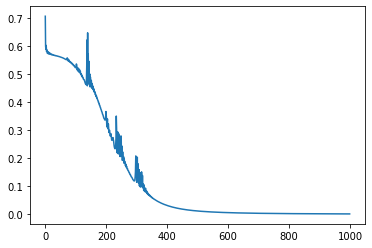

In [36]:
plt.plot(loss_cnn_train)
len(cnn_logits)

In [64]:
train.to_csv('train_withlogits.csv')

In [65]:
test.to_csv('test_withlogits.csv')

In [42]:
#train = pd.read_csv('train_withlogits.csv')
test = pd.read_csv('test_withlogits.csv')

In [40]:
train['CNN_logits'] =cnn_logits.detach().cpu().numpy()

In [66]:
test

,Unnamed: 0,Unnamed: 0.1,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits
0,0,1246,साया,سایه,saːjaː,sɒjh,0.666667,0.166667,0.062500,0.069444,1.187500,0.666667,1,0.610435,0.627098,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...",8.067153,13.088353
1,1,524,तल्ख़ी,تَوَجُّه,təlxiː,towæd͡ʒُّh,0.900000,0.200000,0.177083,0.200000,2.262500,0.900000,0,0.492522,0.449687,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...","[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...",-11.186650,-20.759451
2,2,7655,उदार,سخاوتمندانه,udaːr,sxɒvtmndɒnh,0.909091,0.636364,0.615530,0.681818,5.102273,0.909091,0,0.340180,0.758899,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...","[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...",-7.928271,-9.596358
3,3,12060,हम-,هرگز,ɦəmə-,hrɡz,1.000000,0.600000,0.166667,0.208333,3.650000,1.000000,0,0.333505,0.659417,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...","[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...",-20.914663,-19.077866
4,4,1962,कठोर,بي تفاوت,kəʈʰor,bي tfɒvt,1.000000,0.625000,0.247396,0.281250,3.250000,1.000000,0,0.369706,0.487233,"[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...","[-1, 1, -1, -1, -1, -1, -1, 0, -1, -1, 1, -1, ...",-9.150852,-8.425693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,498,1047,रफ़्तार,رفتار,rəftaːr,rftɒr,0.428571,0.142857,0.145833,0.160714,1.250000,0.428571,1,0.340994,0.629839,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",8.593673,10.353712
499,499,412,ज़ब्त,ضبط,zəbtə,zbt,0.400000,0.400000,0.358333,0.400000,2.900000,0.400000,1,0.466774,0.746048,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...",9.795804,14.636103
500,500,2127,फ़िरंगी,فرصت,firəŋɡiː,frst,0.750000,0.625000,0.403646,0.453125,3.750000,0.750000,0,0.498239,0.715128,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...",-11.355590,-9.454258
501,501,8432,साज़,اتصال,saːz,ɒtsɒl,1.000000,0.600000,0.404167,0.441667,3.700000,1.000000,0,0.390779,0.225417,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...",-10.104707,-10.157057


# Getting logits from CNN test set

In [56]:
class Net_test(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 2) # input is 1 image, 32 output channels, 2X2 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 2) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128,2)
        

        #x = torch.randn(23,23).view(-1,1,23,23)
        x = torch.randn(30,30).view(-1,1,30,30)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 1) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.tanh(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.tanh(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.tanh(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.tanh(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.sigmoid(x), x, #comment it out to get the logits in the return statement 
        #return x
                         


net = Net_test().to(device)
print(net)

Net_test(
  (conv1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


In [57]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
#loss_function = nn.MSELoss()
loss_function = nn.BCELoss().to(device)

In [58]:
loss_cnn_test = []
EPOCHS = 1000
BATCH_SIZE = 120
cnn_logits_lst_test = []
 
for epoch in range(EPOCHS):
    #for i in tqdm(range(0, len(X_train_CNN), BATCH_SIZE)):
    batch_X = X_test_CNN.view(-1, 1, 30,30)
    batch_y = Y_test_CNN


    net.zero_grad()
    outputs = net(batch_X.float())[0]
    cnn_logits_test = net(batch_X.float())[1]
    #cnn_logits_lst.extend(cnn_logits)
    #print(outputs)
    loss = loss_function(outputs,  batch_y.float().reshape((-1,1)))

    loss.backward()
    optimizer.step()
    loss_cnn_test.append(loss)
    if EPOCHS % 100 == 0:
        print(f"Epoch: {epoch}. Loss: {loss}")

/s/chopin/d/proj/ramfis-aida/venv/lib64/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0. Loss: 0.6659427881240845
Epoch: 1. Loss: 0.5978161692619324
Epoch: 2. Loss: 0.6174956560134888
Epoch: 3. Loss: 0.5982579588890076
Epoch: 4. Loss: 0.6039654016494751
Epoch: 5. Loss: 0.6058598160743713
Epoch: 6. Loss: 0.5957740545272827
Epoch: 7. Loss: 0.5953888297080994
Epoch: 8. Loss: 0.5996629595756531
Epoch: 9. Loss: 0.59706711769104
Epoch: 10. Loss: 0.5920834541320801
Epoch: 11. Loss: 0.5911952257156372
Epoch: 12. Loss: 0.5929105281829834
Epoch: 13. Loss: 0.5925589799880981
Epoch: 14. Loss: 0.5896614789962769
Epoch: 15. Loss: 0.5872009992599487
Epoch: 16. Loss: 0.5869786143302917
Epoch: 17. Loss: 0.5873532295227051
Epoch: 18. Loss: 0.5859675407409668
Epoch: 19. Loss: 0.5833234190940857
Epoch: 20. Loss: 0.581549882888794
Epoch: 21. Loss: 0.5810942053794861
Epoch: 22. Loss: 0.580150842666626
Epoch: 23. Loss: 0.5776745080947876
Epoch: 24. Loss: 0.5751029849052429
Epoch: 25. Loss: 0.5737095475196838
Epoch: 26. Loss: 0.5720832943916321
Epoch: 27. Loss: 0.5689350366592407
Epoch:

Epoch: 242. Loss: 0.023757802322506905
Epoch: 243. Loss: 0.02420501969754696
Epoch: 244. Loss: 0.024792956188321114
Epoch: 245. Loss: 0.025325169786810875
Epoch: 246. Loss: 0.025550346821546555
Epoch: 247. Loss: 0.02520829625427723
Epoch: 248. Loss: 0.024534642696380615
Epoch: 249. Loss: 0.023822985589504242
Epoch: 250. Loss: 0.023314081132411957
Epoch: 251. Loss: 0.023020150139927864
Epoch: 252. Loss: 0.022891227155923843
Epoch: 253. Loss: 0.02287665195763111
Epoch: 254. Loss: 0.02294742502272129
Epoch: 255. Loss: 0.023093320429325104
Epoch: 256. Loss: 0.023322902619838715
Epoch: 257. Loss: 0.023649021983146667
Epoch: 258. Loss: 0.024042177945375443
Epoch: 259. Loss: 0.024435119703412056
Epoch: 260. Loss: 0.02465064451098442
Epoch: 261. Loss: 0.02461429126560688
Epoch: 262. Loss: 0.024289075285196304
Epoch: 263. Loss: 0.023866044357419014
Epoch: 264. Loss: 0.0234562698751688
Epoch: 265. Loss: 0.02315373718738556
Epoch: 266. Loss: 0.02295735850930214
Epoch: 267. Loss: 0.022847216576337

Epoch: 487. Loss: 0.023145703598856926
Epoch: 488. Loss: 0.022812338545918465
Epoch: 489. Loss: 0.022603899240493774
Epoch: 490. Loss: 0.022481633350253105
Epoch: 491. Loss: 0.022412804886698723
Epoch: 492. Loss: 0.022376026958227158
Epoch: 493. Loss: 0.02235713228583336
Epoch: 494. Loss: 0.022347845137119293
Epoch: 495. Loss: 0.022344360128045082
Epoch: 496. Loss: 0.022345054894685745
Epoch: 497. Loss: 0.022349387407302856
Epoch: 498. Loss: 0.0223578829318285
Epoch: 499. Loss: 0.0223736222833395
Epoch: 500. Loss: 0.022402510046958923
Epoch: 501. Loss: 0.022452177479863167
Epoch: 502. Loss: 0.02253800444304943
Epoch: 503. Loss: 0.022690054029226303
Epoch: 504. Loss: 0.022953703999519348
Epoch: 505. Loss: 0.023371538147330284
Epoch: 506. Loss: 0.023950520902872086
Epoch: 507. Loss: 0.024594413116574287
Epoch: 508. Loss: 0.024988295510411263
Epoch: 509. Loss: 0.02489127777516842
Epoch: 510. Loss: 0.024321360513567924
Epoch: 511. Loss: 0.02364921011030674
Epoch: 512. Loss: 0.0230883583426

Epoch: 732. Loss: 0.0226780716329813
Epoch: 733. Loss: 0.02276698499917984
Epoch: 734. Loss: 0.02286781556904316
Epoch: 735. Loss: 0.02297261729836464
Epoch: 736. Loss: 0.02307468093931675
Epoch: 737. Loss: 0.02314705215394497
Epoch: 738. Loss: 0.023176101967692375
Epoch: 739. Loss: 0.023156171664595604
Epoch: 740. Loss: 0.023102642968297005
Epoch: 741. Loss: 0.02301480621099472
Epoch: 742. Loss: 0.02291283756494522
Epoch: 743. Loss: 0.022813552990555763
Epoch: 744. Loss: 0.022727176547050476
Epoch: 745. Loss: 0.02265132963657379
Epoch: 746. Loss: 0.022587519139051437
Epoch: 747. Loss: 0.022537289187312126
Epoch: 748. Loss: 0.022503376007080078
Epoch: 749. Loss: 0.022484909743070602
Epoch: 750. Loss: 0.022484377026557922
Epoch: 751. Loss: 0.02250019647181034
Epoch: 752. Loss: 0.022534072399139404
Epoch: 753. Loss: 0.02258383296430111
Epoch: 754. Loss: 0.02265206351876259
Epoch: 755. Loss: 0.022733459249138832
Epoch: 756. Loss: 0.022829843685030937
Epoch: 757. Loss: 0.02292938530445099


Epoch: 977. Loss: 0.022616669535636902
Epoch: 978. Loss: 0.02265785075724125
Epoch: 979. Loss: 0.02269297093153
Epoch: 980. Loss: 0.02272936888039112
Epoch: 981. Loss: 0.022761695086956024
Epoch: 982. Loss: 0.02279050275683403
Epoch: 983. Loss: 0.022807393223047256
Epoch: 984. Loss: 0.02280762977898121
Epoch: 985. Loss: 0.022795386612415314
Epoch: 986. Loss: 0.022774552926421165
Epoch: 987. Loss: 0.022744195535779
Epoch: 988. Loss: 0.02270529605448246
Epoch: 989. Loss: 0.02266089804470539
Epoch: 990. Loss: 0.022621817886829376
Epoch: 991. Loss: 0.022593408823013306
Epoch: 992. Loss: 0.02257687970995903
Epoch: 993. Loss: 0.022569691762328148
Epoch: 994. Loss: 0.022565634921193123
Epoch: 995. Loss: 0.022563159465789795
Epoch: 996. Loss: 0.02256385050714016
Epoch: 997. Loss: 0.02256523072719574
Epoch: 998. Loss: 0.02257007360458374
Epoch: 999. Loss: 0.022583208978176117


503

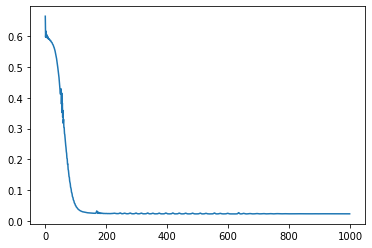

In [59]:
plt.plot(loss_cnn_test)
len(cnn_logits_test)

In [61]:
test['CNN_logits'] =cnn_logits_test.detach().cpu().numpy()

In [62]:
test

,Unnamed: 0,Unnamed: 0.1,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits
0,0,1246,साया,سایه,saːjaː,sɒjh,0.666667,0.166667,0.062500,0.069444,1.187500,0.666667,1,0.610435,0.627098,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...",8.067153,13.088353
1,1,524,तल्ख़ी,تَوَجُّه,təlxiː,towæd͡ʒُّh,0.900000,0.200000,0.177083,0.200000,2.262500,0.900000,0,0.492522,0.449687,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...","[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...",-11.186650,-20.759451
2,2,7655,उदार,سخاوتمندانه,udaːr,sxɒvtmndɒnh,0.909091,0.636364,0.615530,0.681818,5.102273,0.909091,0,0.340180,0.758899,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...","[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...",-7.928271,-9.596358
3,3,12060,हम-,هرگز,ɦəmə-,hrɡz,1.000000,0.600000,0.166667,0.208333,3.650000,1.000000,0,0.333505,0.659417,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...","[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...",-20.914663,-19.077866
4,4,1962,कठोर,بي تفاوت,kəʈʰor,bي tfɒvt,1.000000,0.625000,0.247396,0.281250,3.250000,1.000000,0,0.369706,0.487233,"[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...","[-1, 1, -1, -1, -1, -1, -1, 0, -1, -1, 1, -1, ...",-9.150852,-8.425693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,498,1047,रफ़्तार,رفتار,rəftaːr,rftɒr,0.428571,0.142857,0.145833,0.160714,1.250000,0.428571,1,0.340994,0.629839,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",8.593673,10.353712
499,499,412,ज़ब्त,ضبط,zəbtə,zbt,0.400000,0.400000,0.358333,0.400000,2.900000,0.400000,1,0.466774,0.746048,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...",9.795804,14.636103
500,500,2127,फ़िरंगी,فرصت,firəŋɡiː,frst,0.750000,0.625000,0.403646,0.453125,3.750000,0.750000,0,0.498239,0.715128,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...",-11.355590,-9.454258
501,501,8432,साज़,اتصال,saːz,ɒtsɒl,1.000000,0.600000,0.404167,0.441667,3.700000,1.000000,0,0.390779,0.225417,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...",-10.104707,-10.157057


# Classifiers on final train/test set: logistic reg, SVM(rbf), Random Forest etc

In [84]:
import sklearn as sk
from sklearn.linear_model import LogisticRegression

In [67]:
test = pd.read_csv('test_withlogits.csv')

In [68]:
train = pd.read_csv('train_withlogits.csv')

# Try both a miniature train-like test set and a class-balanced test set

In [571]:
features =  ['Fast Levenshtein', 'Dolgo Prime Distance',
       'Feature Edit Distance', 'Hamming Feature Distance',
       'Weighted Feature Distance', 'Fast Levenshtein Distance Div Maxlen','mbert_cos_similarity', 'xlm_cos_similarity',
             'CNN_logits', 'DNN_logits'
        ]

# features =  ['Fast Levenshtein', 'Dolgo Prime Distance',
#        'Feature Edit Distance', 'Hamming Feature Distance',
#        'Weighted Feature Distance', 'Fast Levenshtein Distance Div Maxlen', 
#         ]

labels = ['label']

In [517]:
idx = test['label']==0
testneg = test.loc[idx][:140] 
testpos = test.loc[test['label']==1]

In [521]:
testneg.shape, testpos.shape
test_balanced = pd.concat([testpos, testneg])
test_balanced.shape

(283, 20)

In [578]:
x_train = train[features].values
y_train = train[labels].values.ravel()
x_test = test[features].values
y_test = test[labels].values.ravel()

# x_test = test_balanced[features].values
# y_test = test_balanced[labels].values.ravel()


In [579]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4398, 10), (4398,), (503, 10), (503,))

In [446]:
y_train

array([1, 0, 0, ..., 0, 0, 1])

In [447]:
x_train

array([[  0.5       ,   0.16666667,   0.17013889, ...,   0.56327808,
          6.492431  ,  10.236605  ],
       [  0.71428571,   0.42857143,   0.30059524, ...,   0.71721417,
        -10.887565  ,  -6.9346147 ],
       [  0.78947368,   0.52631579,   0.33881579, ...,   0.28867748,
        -55.091427  , -48.7657    ],
       ...,
       [  1.        ,   0.77777778,   0.37962963, ...,   0.31559917,
        -30.561073  , -19.542866  ],
       [  0.83333333,   0.66666667,   0.27083333, ...,   0.68230748,
        -23.322008  , -12.497076  ],
       [  0.57142857,   0.28571429,   0.18154762, ...,   0.22730209,
         16.455185  ,   8.119109  ]])

# Train a binary logistic regression classifier and testing with logits plus edit dist and cosine sims  as features: 10 features total: 

In [570]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [580]:
#try after standardizing the data including the logits. 
# stand= StandardScaler()
# fit = stand.fit(x_train)
# x_train = fit.transform(x_train)

# x_test = fit.transform(x_test)

In [581]:
LR = LogisticRegression(random_state=1, solver='lbfgs', multi_class='ovr', max_iter=500 ).fit(x_train, y_train)

In [582]:
y_pred = LR.predict(x_test)

In [583]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

f1-score :  0.9727891156462585
precision :  0.9470198675496688
recall :  1.0
accuracy :  0.9840954274353877
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       360
           1       0.95      1.00      0.97       143

    accuracy                           0.98       503
   macro avg       0.97      0.99      0.98       503
weighted avg       0.98      0.98      0.98       503

[[352   8]
 [  0 143]]


In [584]:
unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])

In [585]:
tp = np.array(np.where(unq == 3)).tolist()[0]
fp = np.array(np.where(unq == 1)).tolist()[0]
tn = np.array(np.where(unq == 0)).tolist()[0]
fn = np.array(np.where(unq == 2)).tolist()[0]

# for train-like test set, recall is very high with a slightly lower precision, 8 FP and no FN

In [588]:
test.iloc[fp,:]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits
40,40,40,5962,रहस्यमय,پنهان شده است,rəɦsjəməj,پnhɒn ʃdh ɒst,1.000000,0.461538,0.219551,0.246795,3.423077,1.000000,0,0.253508,0.493680,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...",-0.042522,0.281467
62,62,62,12493,जन्नत,جواب,d͡ʒənnət,d͡ʒvɒb,0.625000,0.500000,0.291667,0.322917,2.734375,0.625000,0,0.459989,0.700303,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...",-0.089799,0.389173
129,129,129,7532,बदतरीन,بدولت,bədtəriːn,bdvlt,0.777778,0.555556,0.349537,0.398148,3.166667,0.777778,0,0.530160,0.622041,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",-0.038698,0.163530
142,142,142,4113,अशुद्ध,نجس,aʃudd̤ə,nd͡ʒs,0.857143,0.714286,0.455357,0.500000,4.142857,0.857143,0,0.516118,0.581282,"[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...","[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...",-0.068214,0.332891
190,190,190,12290,क़ैंची,کامیاب,qæːɲt͡ʃiː,kɒmjɒb,1.000000,0.333333,0.189815,0.203704,2.236111,1.000000,0,0.438396,0.638663,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...",-0.098507,0.356058
209,209,209,1144,शबनम,شمشیر,ʃəbnəm,ʃmʃjr,0.833333,0.833333,0.277778,0.319444,3.541667,0.833333,0,0.687149,0.806896,"[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...","[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...",-0.089616,0.381455
326,326,326,11818,राज़ी,رشوه,raːziː,rʃvh,0.833333,0.500000,0.121528,0.145833,2.520833,0.833333,0,0.663253,0.647947,"[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...","[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...",-0.048472,0.210873
386,386,386,1817,जुमा,جستجو,d͡ʒumaː,d͡ʒstd͡ʒv,0.666667,0.444444,0.210648,0.236111,3.152778,0.666667,0,0.455464,0.624441,"[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...","[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...",-0.080514,0.349072


In [587]:
test.iloc[fn,:]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits


In [550]:
#try after standardizing the data including the logits. 
stand= StandardScaler()
fit = stand.fit(x_train)
x_train = fit.transform(x_train)

x_test = fit.transform(x_test)

In [567]:

LR = LogisticRegression(random_state=1, solver='lbfgs', multi_class='ovr', max_iter=500 ).fit(x_train, y_train)

In [568]:
y_pred = LR.predict(x_test)

In [569]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

f1-score :  0.9225092250922509
precision :  0.9765625
recall :  0.8741258741258742
accuracy :  0.9257950530035336
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       140
           1       0.98      0.87      0.92       143

    accuracy                           0.93       283
   macro avg       0.93      0.93      0.93       283
weighted avg       0.93      0.93      0.93       283

[[137   3]
 [ 18 125]]


In [555]:
precision, recall, fscore, support = score(y_pred, y_test, pos_label=1)

In [556]:
print('fscore: {}'.format(fscore))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

print('support: {}'.format(support))

fscore: [0.92881356 0.92250923]
precision: [0.97857143 0.87412587]
recall: [0.88387097 0.9765625 ]
support: [155 128]


In [455]:
sum(y_train==0)

3198

In [560]:
unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])

In [561]:
tp = np.array(np.where(unq == 3)).tolist()[0]
fp = np.array(np.where(unq == 1)).tolist()[0]
tn = np.array(np.where(unq == 0)).tolist()[0]
fn = np.array(np.where(unq == 2)).tolist()[0]

In [564]:
test_balanced.iloc[fp,:]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits
78,78,78,11390,दुश्वार,دور,duʃvaːr,dvr,0.571429,0.428571,0.386905,0.428571,3.107143,0.571429,0,0.428112,0.321477,"[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, 1, 1,...","[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, 1, 1,...",-8.963047,-11.555681
94,94,94,8530,जामा,جگر,d͡ʒaːmaː,d͡ʒɡr,0.625000,0.375000,0.182292,0.213542,2.281250,0.625000,0,0.630003,0.612502,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...",-13.170180,-7.685933
182,182,182,9841,ज़र्रा,زار زار,zərraː,zɒr zɒr,0.714286,0.285714,0.172619,0.208333,1.857143,0.714286,0,0.462647,0.596593,"[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...","[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...",-7.707266,-11.462407


In [563]:
test_balanced.iloc[fn,:]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits
66,66,66,4,अंदरुनी,اندرونی,ndəruniː,ɒndrvnj,0.625000,0.500000,0.153646,0.182292,3.171875,0.625000,1,0.484583,0.788032,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",8.576007,8.895311
71,71,71,604,-दान,دانستن,-daːn,dɒnstn,0.833333,0.500000,0.479167,0.520833,3.875000,0.833333,1,0.293757,0.621542,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",6.620969,7.180840
76,76,76,601,दहेज़,جهیز,dəɦez,d͡ʒhjz,0.666667,0.500000,0.197917,0.222222,1.937500,0.666667,1,0.466845,0.620716,"[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, 1, 1...","[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, -1, -...",29.674936,10.942152
81,81,81,526,तश्तरी,تشت,təʃtəriː,tʃt,0.625000,0.500000,0.440104,0.500000,3.625000,0.625000,1,0.590817,0.547848,"[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...","[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, 1, ...",14.743056,10.560655
92,92,92,1236,सही,صحیح,səɦiː,shjh,0.800000,0.400000,0.108333,0.125000,2.650000,0.800000,1,0.488294,0.608805,"[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, 1, 1,...","[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, 1, 1,...",8.049563,8.439472
107,107,107,272,ख़ुशनवीसी,خُوشنَوِیسی,xuʃnəviːsiː,xُvʃnowejsj,0.727273,0.363636,0.160985,0.181818,2.363636,0.727273,1,0.560712,0.560799,"[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...","[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...",7.862397,8.812596
112,112,112,727,पहल,پهلو,pəɦəl,پhlv,1.000000,0.800000,0.462500,0.516667,4.775000,1.000000,1,0.708759,0.752857,"[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, 1, 1...","[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, 1, 1...",8.313698,9.281388
136,136,136,76,आलू,آلو,aːluː,ɒlv,0.800000,0.200000,0.095833,0.108333,2.000000,0.800000,1,0.625537,0.419534,"[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, 1, ...","[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, 1, ...",8.036224,11.560460
167,167,167,781,फ़िरंगी,فرنگی,firəŋɡiː,frŋj,0.625000,0.500000,0.351562,0.395833,3.078125,0.625000,1,0.574454,0.696136,"[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...","[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...",7.528652,8.187250
220,220,220,725,पहरा,پهره,pəɦraː,پhrh,0.833333,0.500000,0.347222,0.388889,3.395833,0.833333,1,0.700302,0.729959,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",6.872724,6.540695


# Train a binary logistic regression classifier and testing with   edit dist as features only

In [539]:
features =  ['Fast Levenshtein', 'Dolgo Prime Distance',
       'Feature Edit Distance', 'Hamming Feature Distance',
       'Weighted Feature Distance', 'Fast Levenshtein Distance Div Maxlen', 
        ]

In [540]:
x_train = train[features].values
y_train = train[labels].values.ravel()
x_test = test[features].values
y_test = test[labels].values.ravel()

In [541]:
# stand= StandardScaler()
# fit = stand.fit(x_train)
# x_train = fit.transform(x_train)

# x_test = fit.transform(x_test)

In [542]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4398, 6), (4398,), (503, 6), (503,))

In [463]:

LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', max_iter=500 ).fit(x_train, y_train)

In [464]:
y_pred = LR.predict(x_test)

In [465]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))

f1-score :  0.8873239436619719
precision :  0.8936170212765957
recall :  0.8811188811188811
accuracy :  0.9363817097415507


In [466]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       360
           1       0.89      0.88      0.89       143

    accuracy                           0.94       503
   macro avg       0.92      0.92      0.92       503
weighted avg       0.94      0.94      0.94       503



# Train a binary logistic regression classifier and testing with   edit dist and cosine sims as features

In [467]:
features =  ['Fast Levenshtein', 'Dolgo Prime Distance',
       'Feature Edit Distance', 'Hamming Feature Distance',
       'Weighted Feature Distance', 'Fast Levenshtein Distance Div Maxlen','mbert_cos_similarity', 'xlm_cos_similarity',
             
        ]

In [468]:
x_train = train[features].values
y_train = train[labels].values.ravel()
x_test = test[features].values
y_test = test[labels].values.ravel()

In [469]:
# stand= StandardScaler()
# fit = stand.fit(x_train)
# x_train = fit.transform(x_train)

# x_test = fit.transform(x_test)

In [470]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4398, 8), (4398,), (503, 8), (503,))

In [471]:

LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', max_iter=500 ).fit(x_train, y_train)

In [472]:
y_pred = LR.predict(x_test)

In [473]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

f1-score :  0.881118881118881
precision :  0.8811188811188811
recall :  0.8811188811188811
accuracy :  0.9324055666003976
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       360
           1       0.88      0.88      0.88       143

    accuracy                           0.93       503
   macro avg       0.92      0.92      0.92       503
weighted avg       0.93      0.93      0.93       503



# Try with SVM with various combinations of features

In [474]:
from sklearn import svm


In [475]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(x_train, y_train)

SVC(kernel='linear')

In [476]:
y_pred = svclassifier.predict(x_test)

In [477]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

f1-score :  0.8842105263157896
precision :  0.8873239436619719
recall :  0.8811188811188811
accuracy :  0.9343936381709742
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       360
           1       0.89      0.88      0.88       143

    accuracy                           0.93       503
   macro avg       0.92      0.92      0.92       503
weighted avg       0.93      0.93      0.93       503



# with all 10 features 

In [478]:
features =  ['Fast Levenshtein', 'Dolgo Prime Distance',
       'Feature Edit Distance', 'Hamming Feature Distance',
       'Weighted Feature Distance', 'Fast Levenshtein Distance Div Maxlen','mbert_cos_similarity', 'xlm_cos_similarity',
             'CNN_logits', 'DNN_logits'
        ]

In [479]:
x_train = train[features].values
y_train = train[labels].values.ravel()
x_test = test[features].values
y_test = test[labels].values.ravel()

In [480]:
# stand= StandardScaler()
# fit = stand.fit(x_train)
# x_train = fit.transform(x_train)

# x_test = fit.transform(x_test)

In [481]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(x_train, y_train)

SVC()

In [482]:
y_pred = svclassifier.predict(x_test)

In [483]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

f1-score :  0.9727891156462585
precision :  0.9470198675496688
recall :  1.0
accuracy :  0.9840954274353877
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       360
           1       0.95      1.00      0.97       143

    accuracy                           0.98       503
   macro avg       0.97      0.99      0.98       503
weighted avg       0.98      0.98      0.98       503



# with edit distances and cosine sim: 8 features

In [484]:
features =  ['Fast Levenshtein', 'Dolgo Prime Distance',
       'Feature Edit Distance', 'Hamming Feature Distance',
       'Weighted Feature Distance', 'Fast Levenshtein Distance Div Maxlen','mbert_cos_similarity', 'xlm_cos_similarity',
             
        ]

In [485]:
x_train = train[features].values
y_train = train[labels].values.ravel()
x_test = test[features].values
y_test = test[labels].values.ravel()

In [486]:
# stand= StandardScaler()
# fit = stand.fit(x_train)
# x_train = fit.transform(x_train)

# x_test = fit.transform(x_test)

In [487]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4398, 8), (4398,), (503, 8), (503,))

In [488]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(x_train, y_train)

SVC()

In [489]:
y_pred = svclassifier.predict(x_test)

In [490]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

f1-score :  0.8936170212765958
precision :  0.9064748201438849
recall :  0.8811188811188811
accuracy :  0.9403578528827038
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       360
           1       0.91      0.88      0.89       143

    accuracy                           0.94       503
   macro avg       0.93      0.92      0.93       503
weighted avg       0.94      0.94      0.94       503

[[347  13]
 [ 17 126]]


# Random forest

In [491]:
from sklearn.ensemble import RandomForestClassifier


In [492]:
RF = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)

# with 8 features, edits and cosine w/o logits

In [493]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4398, 8), (4398,), (503, 8), (503,))

In [494]:
stand= StandardScaler()
fit = stand.fit(x_train)
x_train = fit.transform(x_train)

x_test = fit.transform(x_test)

In [495]:
RF.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=0)

In [496]:
y_pred = RF.predict(x_test)

In [497]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

f1-score :  0.8936170212765958
precision :  0.9064748201438849
recall :  0.8811188811188811
accuracy :  0.9403578528827038
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       360
           1       0.91      0.88      0.89       143

    accuracy                           0.94       503
   macro avg       0.93      0.92      0.93       503
weighted avg       0.94      0.94      0.94       503

[[347  13]
 [ 17 126]]


# 10 features, all with Random Forests

In [498]:
features =  ['Fast Levenshtein', 'Dolgo Prime Distance',
       'Feature Edit Distance', 'Hamming Feature Distance',
       'Weighted Feature Distance', 'Fast Levenshtein Distance Div Maxlen','mbert_cos_similarity', 'xlm_cos_similarity',
             'CNN_logits', 'DNN_logits'
        ]

In [499]:
x_train = train[features].values
y_train = train[labels].values.ravel()
x_test = test[features].values
y_test = test[labels].values.ravel()

In [500]:
stand= StandardScaler()
fit = stand.fit(x_train)
x_train = fit.transform(x_train)

x_test = fit.transform(x_test)

In [501]:
RF = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)

In [502]:
RF.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=0)

In [503]:
y_pred = RF.predict(x_test)

In [504]:
print("f1-score : ", f1_score(y_test, y_pred ))
print("precision : ",precision_score(y_test, y_pred))
print("recall : ",recall_score(y_test, y_pred )) 
print("accuracy : ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

f1-score :  0.9750889679715302
precision :  0.9927536231884058
recall :  0.958041958041958
accuracy :  0.9860834990059643
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       360
           1       0.99      0.96      0.98       143

    accuracy                           0.99       503
   macro avg       0.99      0.98      0.98       503
weighted avg       0.99      0.99      0.99       503

[[359   1]
 [  6 137]]


In [505]:
unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])

In [506]:
tp = np.array(np.where(unq == 3)).tolist()[0]
fp = np.array(np.where(unq == 1)).tolist()[0]
tn = np.array(np.where(unq == 0)).tolist()[0]
fn = np.array(np.where(unq == 2)).tolist()[0]

In [507]:
fn

[59, 203, 363, 399, 458, 492]

In [508]:
test.iloc[fn,:]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits
59,59,59,589,दर्ज़ी,درزی,dərziː,drzj,0.500000,0.333333,0.170139,0.194444,1.687500,0.500000,1,0.548778,0.457338,"[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...","[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...",-0.048472,0.210873
203,203,203,804,बजाय,بجای,bəd͡ʒaːj,bd͡ʒɒj,0.375000,0.125000,0.127604,0.140625,1.093750,0.375000,1,0.554636,0.697365,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",-0.038698,0.163530
363,363,363,775,फ़ारसी,فارسی,faːrsiː,fɒrsj,0.571429,0.142857,0.035714,0.041667,0.625000,0.571429,1,0.461557,0.759727,"[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...","[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...",-0.068214,0.332891
399,399,399,1291,हकीम,حکیم,ɦəkiːm,hkjm,0.666667,0.333333,0.177083,0.201389,1.729167,0.666667,1,0.517663,0.650957,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...",-0.098507,0.356058
458,458,458,554,तुर्की,ترکی,turkiː,trkj,0.500000,0.333333,0.170139,0.194444,1.687500,0.500000,1,0.700281,0.403561,"[1, 1, -1, 1, -1, -1, -1, 0, 1, -1, -1, 0, -1,...","[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...",-0.089616,0.381455
492,492,492,749,पैग़ाम,پیغام,pæːɣaːm,پjɣɒm,0.714286,0.285714,0.175595,0.196429,1.803571,0.714286,1,0.577389,0.793600,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...",-0.089799,0.389173


In [509]:
test.iloc[fp,:]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits
62,62,62,12493,जन्नत,جواب,d͡ʒənnət,d͡ʒvɒb,0.625,0.5,0.291667,0.322917,2.734375,0.625,0,0.459989,0.700303,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, -...",-0.089799,0.389173


In [510]:
test.iloc[tp,:]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits
0,0,0,1246,साया,سایه,saːjaː,sɒjh,0.666667,0.166667,0.062500,0.069444,1.187500,0.666667,1,0.610435,0.627098,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...",8.067153,13.088353
5,5,5,743,पेचकस,پیچ کش,pet͡ʃkəs,پjt͡ʃ kʃ,0.625000,0.375000,0.250000,0.281250,2.265625,0.625000,1,0.524065,0.851965,"[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, 1, 1,...","[-1, -1, 1, -1, 1, -1, -1, 0, 1, -1, -1, -1, 1...",7.977158,9.532843
7,7,7,154,क़तार,قطار,qətaːr,ɣtɒr,0.666667,0.166667,0.190972,0.208333,1.750000,0.666667,1,0.496417,0.828683,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...",8.294688,8.501902
8,8,8,702,पंजा,پنجه,pəɲd͡ʒaː,پnd͡ʒh,0.625000,0.375000,0.273438,0.307292,2.718750,0.625000,1,0.566448,0.512996,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",7.139163,10.420475
9,9,9,410,ज़बान,زبان,zəbaːn,zbɒn,0.500000,0.166667,0.170139,0.187500,1.458333,0.500000,1,0.407726,0.327706,"[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...","[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...",6.765188,7.704823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,482,482,1261,सिरका,سرکه,sirkaː,srkh,0.500000,0.333333,0.190972,0.215278,2.145833,0.500000,1,0.607168,0.641863,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, -1, -...",6.061551,6.145308
485,485,485,1059,राय,رأی,raːj,rɒʔj,0.500000,0.250000,0.255208,0.281250,2.187500,0.500000,1,0.490000,0.678451,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, -1, -...",7.641813,9.061541
494,494,494,137,ओहदा,عهده,oɦdaː,ʔhdh,0.800000,0.400000,0.116667,0.133333,2.150000,0.800000,1,0.249290,0.475189,"[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...","[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...",8.374212,8.988889
498,498,498,1047,रफ़्तार,رفتار,rəftaːr,rftɒr,0.428571,0.142857,0.145833,0.160714,1.250000,0.428571,1,0.340994,0.629839,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",8.593673,10.353712


In [511]:
test.iloc[tp,:]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label,mbert_cos_similarity,xlm_cos_similarity,features_loan,features_orig,DNN_logits,CNN_logits
0,0,0,1246,साया,سایه,saːjaː,sɒjh,0.666667,0.166667,0.062500,0.069444,1.187500,0.666667,1,0.610435,0.627098,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...",8.067153,13.088353
5,5,5,743,पेचकस,پیچ کش,pet͡ʃkəs,پjt͡ʃ kʃ,0.625000,0.375000,0.250000,0.281250,2.265625,0.625000,1,0.524065,0.851965,"[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, 1, 1,...","[-1, -1, 1, -1, 1, -1, -1, 0, 1, -1, -1, -1, 1...",7.977158,9.532843
7,7,7,154,क़तार,قطار,qətaːr,ɣtɒr,0.666667,0.166667,0.190972,0.208333,1.750000,0.666667,1,0.496417,0.828683,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, 1, 1, -1, -1, -1, 1, 0, 1, -1, -1, 1, -1,...",8.294688,8.501902
8,8,8,702,पंजा,پنجه,pəɲd͡ʒaː,پnd͡ʒh,0.625000,0.375000,0.273438,0.307292,2.718750,0.625000,1,0.566448,0.512996,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",7.139163,10.420475
9,9,9,410,ज़बान,زبان,zəbaːn,zbɒn,0.500000,0.166667,0.170139,0.187500,1.458333,0.500000,1,0.407726,0.327706,"[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...","[-1, 1, 1, 1, 0, -1, -1, 0, 1, -1, -1, 1, 1, -...",6.765188,7.704823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,482,482,1261,सिरका,سرکه,sirkaː,srkh,0.500000,0.333333,0.190972,0.215278,2.145833,0.500000,1,0.607168,0.641863,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, -1, -...",6.061551,6.145308
485,485,485,1059,राय,رأی,raːj,rɒʔj,0.500000,0.250000,0.255208,0.281250,2.187500,0.500000,1,0.490000,0.678451,"[-1, -1, 1, -1, -1, -1, -1, 0, -1, -1, -1, -1,...","[-1, -1, 1, 1, -1, -1, -1, 0, 1, -1, -1, -1, -...",7.641813,9.061541
494,494,494,137,ओहदा,عهده,oɦdaː,ʔhdh,0.800000,0.400000,0.116667,0.133333,2.150000,0.800000,1,0.249290,0.475189,"[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...","[-1, -1, 1, 1, -1, -1, -1, 0, -1, -1, -1, -1, ...",8.374212,8.988889
498,498,498,1047,रफ़्तार,رفتار,rəftaːr,rftɒr,0.428571,0.142857,0.145833,0.160714,1.250000,0.428571,1,0.340994,0.629839,"[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...","[-1, -1, 1, -1, -1, -1, -1, 0, 1, -1, -1, 1, 1...",8.593673,10.353712
